<a href="https://colab.research.google.com/github/mohith-vishwanath/GAN_mnist_pytorch/blob/main/GAN_MNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import imageio
import time

# from google.colab import drive
# drive.mount('/content/drive')

##Linear Model (GAN)

In [2]:
#HyperParameters

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Running on {device}')


random_seed = 69
gen_lr = 0.0002 #learning rate for the generator
disc_lr = 0.0002 #learning rate for the discriminator
batch_size = 128 
z_dim = 128 #latent hidden space. This space will be mapped to the MNIST digits
hidden_dim = 256 #used for the number of neurons in the network
num_of_epochs = 200 
img_height, img_width, img_color_channel = 28,28,1
output_dim = 1 #number of outputs of the discriminator

Running on cuda


In [3]:
#Custom transforms to be done on the MNIST digits
# 1. Convert the image to a Tensor
# 2. Normalize the pixel values so that the new distribution has mean and std of 0.5

custom_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [4]:
#Download the dataset
train_dataset = datasets.MNIST(
    root = "",
    train=True,
    download = True,
    transform = custom_transform
)

#Load the dataset into a DataLoader to be used as an iterator while training
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True
)

#Checking the dataset

for image, label in train_loader:
    print("\nImage batch dimensions : ",image.shape)
    print("Image label dimensions : ", label.shape)
    break

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



Image batch dimensions :  torch.Size([128, 1, 28, 28])
Image label dimensions :  torch.Size([128])


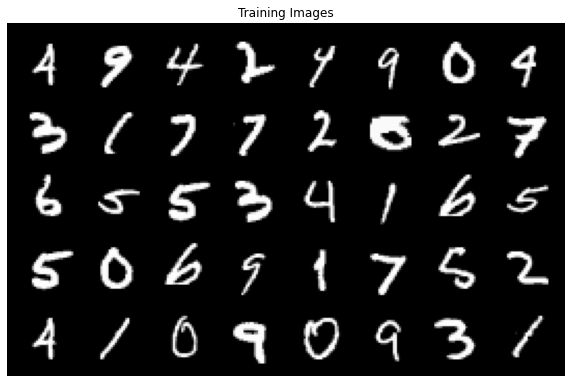

In [5]:
#Randomly pick a few images to be displayed below

num_of_images = 40

random_choice = np.random.choice(np.arange(batch_size),size=num_of_images)
random_images = image[random_choice,:,:,:]

plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(random_images,padding=5,normalize=True),(1,2,0)))
plt.show()

In [34]:
def get_real_labels(length):
    #returns a 2D tensor of shape [1,length] filled with 1s
    return torch.ones(length,device=device,dtype=torch.float32).unsqueeze(dim=1)

def get_fake_labels(length):
    #returns a 2D tensor of shape [1,length] filled with 0s
    return torch.zeros(length,device=device,dtype=torch.float32).unsqueeze(dim=1)

def get_noise_vector(sample_size,noise_dim):
    #returns a 2D tensor of shape [sample_size,noise_dim] filled with random numbers
    return torch.randn(sample_size,noise_dim,device=device,dtype=torch.float32)

def save_generated_images(image,path):
    torchvision.utils.save_image(image,path)

#### Linear Model Architecture

In [6]:
class Discriminator(nn.Module):

    '''
    Parameters

    1. img_dim    -> Refers to the dimensions of the image. The MNIST dataset consists of images of shape 28*28. When flattened, the linear vector will be of shape [784]
    2. hidden_dim -> Refers to the number of neurons in the hidden layers. You can use numbers instead
    3. output_dim -> The dicriminator has only one output. It can have 2 if we chose to use a different loss function (other than binary cross entropy)

    '''


    def __init__(self,img_dim,hidden_dim,output_dim):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim,hidden_dim*4),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim*4,hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim*2,hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim,output_dim),
            nn.Sigmoid()
        )

    def forward(self,x):
        x = x.view(-1,784)
        return self.disc(x)
    

class Generator(nn.Module):

    '''
    Parameters

    1. z_dim      -> Refers to the latent noise space. The generator will learn to map this space to the training set distribution
    2. img_dim    -> Refers to the dimensions of the image. The MNIST dataset consists of images of shape 28*28. When flattened, the linear vector will be of shape [784]
    3. hidden_dim -> Refers to the number of neurons in the hidden layers. You can use numbers instead

    '''


    def __init__(self,z_dim,img_dim,hidden_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim*2),
            nn.ReLU(),
            nn.Linear(hidden_dim*2,hidden_dim*4),
            nn.ReLU(),
            nn.Linear(hidden_dim*4,img_dim),
            nn.Tanh()
        )
    
    def forward(self,x):
        return self.gen(x).view(-1,1,28,28)

In [8]:
#The following generates 2 noise vectors each of size [10]. While training, the noise vector will contain <sample_size> number of vectors each with shape [z_dim]

temp_noise = get_noise_vector(2,10)
temp_noise

tensor([[ 1.2417,  0.0381, -0.4471, -0.3182,  0.7962,  0.5200,  2.0718, -0.0523,
         -1.0534,  0.3725],
        [-0.6515,  0.0127,  0.4307, -0.6268, -0.7079, -1.9534,  0.1484, -0.3366,
          0.4537,  0.3373]], device='cuda:0')

In [9]:
#Create the Generator and Discriminator model
disc_model = Discriminator(img_color_channel*img_height*img_width,hidden_dim,1)
gen_model = Generator(z_dim,img_color_channel*img_height*img_width,hidden_dim)

#Move the model to 'device'. If GPU is available, the model will be moved to the GPU else will run on CPU
disc_model.to(device)
gen_model.to(device)

#Define optimizers for the generator and discriminator models
optim_gen = optim.Adam(gen_model.parameters(),lr=gen_lr)
optim_disc = optim.Adam(disc_model.parameters(),lr=disc_lr)

#Summary of the two models
print(disc_model)
print(gen_model)

Discriminator(
  (disc): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=256, out_features=1, bias=True)
    (9): Sigmoid()
  )
)
Generator(
  (gen): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)


In [10]:
criteria = nn.BCELoss()

In [11]:
loss_gen = []
loss_disc = []
generated_images = []

In [7]:
def train_discriminator(optimizer,real_data,fake_data):
    #get the current batch size
    current_batch_size = real_data.size(0)

    #generate real labels (filled with 1s) and fake labels (filled with 0s)
    real_labels = get_real_labels(current_batch_size)
    fake_labels = get_fake_labels(current_batch_size)

    optimizer.zero_grad()

    #We pass the real and the fake data to the discriminator to see it's performance. We then calculate the loss on the real and the fake data. 
    output_real = disc_model(real_data)
    real_loss = criteria(output_real,real_labels)

    output_fake = disc_model(fake_data)
    fake_loss = criteria(output_fake,fake_labels)

    #The total loss of the discriminator is the sum of loss due to fake data and real data. We could've just added them to get the total loss, taking the average is optional. 
    #By trail and error it was found that the model learns better when we take the average of the loss.
    total_loss = ((real_loss+fake_loss)/2)

    total_loss.backward()
    optimizer.step()

    return total_loss

In [8]:
def train_generator(optimizer,fake_data):
    #get the current batch size
    current_batch_size = fake_data.size(0)
    #generate only real labels (filled with 1s) since this is for the data generated by the generator. 
    real_labels = get_real_labels(current_batch_size)

    optimizer.zero_grad()

    #We send the 
    output = disc_model(fake_data)
    loss = criteria(output,real_labels)

    loss.backward()
    optimizer.step()

    return loss

In [14]:
noise = get_noise_vector(64,z_dim)

gen_model.train()
disc_model.train()

Discriminator(
  (disc): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=256, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

##### **Training**

In [15]:
k_steps = 1

total_start_time = time.time()
for epoch in range(num_of_epochs):
    start_time = time.time()

    #Set the loss of the generator and the discriminator for each epoch zero
    loss_g = 0.0
    loss_d = 0.0

    for batch_idx, (features,_) in enumerate(train_loader):
        image_data = features.to(device)
        batch_size = image_data.size(0)

        #This loop trains the discriminator for k_steps for every generator update
        for _ in range(k_steps):
            #We first generate fake images from the Generator and use that and the real data to train the discriminator
            fake_data = gen_model(get_noise_vector(batch_size,z_dim)).detach()
            real_data = image_data

            loss_d += train_discriminator(optim_disc,real_data,fake_data)

        #get fake data generated by the generator and calculate the loss of the generator
        fake_data = gen_model(get_noise_vector(batch_size,z_dim))
        loss_g += train_generator(optim_gen,fake_data)
    
    #Create the final fake images for the epoch
    generated_fake_images = gen_model(noise).cpu().detach()
    generated_fake_images = torchvision.utils.make_grid(generated_fake_images,padding=5,normalize=True)

    #Saving the images generated by the generator after each epoch
    save_generated_images(generated_fake_images,f'images_from_epoch_{epoch+1}.png')
    generated_images.append(generated_fake_images)

    loss_gen.append(loss_g/batch_idx)
    loss_disc.append(loss_d/batch_idx)

    print(f"Epoch {epoch+1} of {num_of_epochs} | Time taken - {round(time.time()-start_time,3)}s")
    print(f"Generator loss: {(loss_g/batch_idx):.8f}, Discriminator loss: {(loss_d/batch_idx):.8f}")

print(f'Total runtime {round(time.time()-total_start_time,3)}s')

Epoch 1 of 200 | Time taken - 10.164s
Generator loss: 4.65363026, Discriminator loss: 0.20514019
Epoch 2 of 200 | Time taken - 9.887s
Generator loss: 9.29466248, Discriminator loss: 0.09132128
Epoch 3 of 200 | Time taken - 9.781s
Generator loss: 5.40570450, Discriminator loss: 0.24244441
Epoch 4 of 200 | Time taken - 9.732s
Generator loss: 5.13176823, Discriminator loss: 0.10910331
Epoch 5 of 200 | Time taken - 9.87s
Generator loss: 5.42934132, Discriminator loss: 0.10862856
Epoch 6 of 200 | Time taken - 9.735s
Generator loss: 6.62430763, Discriminator loss: 0.07180486
Epoch 7 of 200 | Time taken - 9.641s
Generator loss: 6.56790972, Discriminator loss: 0.10652103
Epoch 8 of 200 | Time taken - 9.798s
Generator loss: 6.97696161, Discriminator loss: 0.08667759
Epoch 9 of 200 | Time taken - 9.68s
Generator loss: 5.81163216, Discriminator loss: 0.08180524
Epoch 10 of 200 | Time taken - 9.638s
Generator loss: 4.91325426, Discriminator loss: 0.10743917
Epoch 11 of 200 | Time taken - 9.694s
Ge

In [39]:
print('DONE TRAINING')
torch.save(gen_model.state_dict(), f'generator.pth') #Saves the generator model's parameters
torch.save(gen_model,f'generator_model.pt') #Saves the entire model
torch.save(optim_gen.state_dict(),f'generator_optimizer.pt') #Saves the state of the optimizer

DONE TRAINING


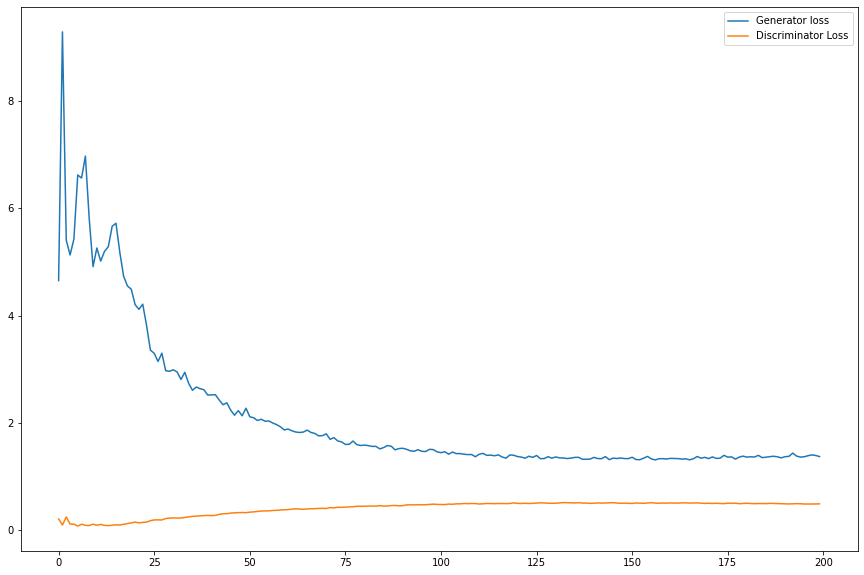

In [17]:
#Visualisation of the errors of Generators and Discriminators

plt.figure(figsize=(15,10))
plt.plot(loss_gen, label='Generator loss')
plt.plot(loss_disc, label='Discriminator Loss')
plt.legend()

**Generating Random Images**

In [53]:
images_to_generate = 56

gen_images = gen_model(get_noise_vector(images_to_generate,z_dim)).cpu().detach()
gen_images.shape

torch.Size([56, 1, 28, 28])

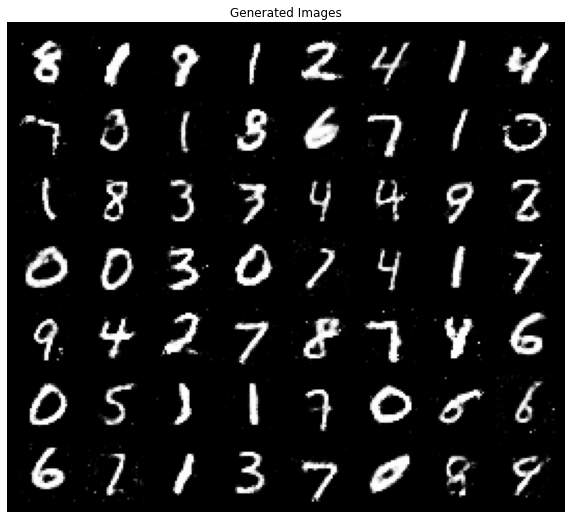

In [54]:
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(gen_images,padding=5,normalize=True),(1,2,0)))
plt.show()